### HW3

* Name: Baldur Hua

* [Github link](https://github.com/BaldurHua/STAT6289-Deep-Learning)

* [Dataset](https://www.kaggle.com/himanigulati/expressions)

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim

In [2]:
# Load the data
filepath = os.path.join(os.getcwd())
df = pd.read_csv(os.path.join(filepath, "TSLA.csv"))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [3]:
df1 = df[['Close']]
sc = MinMaxScaler(feature_range=(0, 1))
df1['Close'] = sc.fit_transform(df1['Close'].values.reshape(-1,1))

<ipython-input-3-bc86f9b72163>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Close'] = sc.fit_transform(df1['Close'].values.reshape(-1,1))


In [4]:
print('Number of rows and columns:', df1.shape)

Number of rows and columns: (1259, 1)


In [5]:
# Train-Test Split
def train_test(stock, step, n):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw)-step): 
        data.append(data_raw[index: index + step])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-n,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-n]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [6]:
# choose sequence length 60 and lag is 1
x_train, y_train, x_test, y_test = train_test(df1, 61, 1)

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:,-1,:]
        out = self.fc(out)

        return out

In [8]:
model = LSTMModel(input_dim=1, hidden_dim=50, layer_dim=4, output_dim=1, dropout_prob=0.2)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
x_train.shape

(958, 60, 1)

In [10]:
X_train = torch.from_numpy(x_train).type(torch.Tensor)
Y_train = torch.from_numpy(y_train).type(torch.Tensor)
epoch = 200
hist = np.zeros(epoch)
lstm = []
for i in range(epoch):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, Y_train)
    print("Epoch ", i, "MSE: ", loss.item())
    hist[i] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

Epoch  0 MSE:  0.007348254788666964
Epoch  1 MSE:  0.04431876912713051
Epoch  2 MSE:  0.003974090330302715
Epoch  3 MSE:  0.002765499986708164
Epoch  4 MSE:  0.004826140124350786
Epoch  5 MSE:  0.004651447292417288
Epoch  6 MSE:  0.0033183398190885782
Epoch  7 MSE:  0.0022311299107968807
Epoch  8 MSE:  0.0023038422223180532
Epoch  9 MSE:  0.002723150420933962
Epoch  10 MSE:  0.002413213485851884
Epoch  11 MSE:  0.0021387231536209583
Epoch  12 MSE:  0.00205684220418334
Epoch  13 MSE:  0.002063166815787554
Epoch  14 MSE:  0.0020974520593881607
Epoch  15 MSE:  0.002136184833943844
Epoch  16 MSE:  0.0021291004959493876
Epoch  17 MSE:  0.0021118796430528164
Epoch  18 MSE:  0.0020915349014103413
Epoch  19 MSE:  0.0020683452021330595
Epoch  20 MSE:  0.0020554105285555124
Epoch  21 MSE:  0.0020521855913102627
Epoch  22 MSE:  0.0020662019960582256
Epoch  23 MSE:  0.002082460792735219
Epoch  24 MSE:  0.0020942247938364744
Epoch  25 MSE:  0.0020927428267896175
Epoch  26 MSE:  0.002069387584924698

In [11]:
pred = pd.DataFrame(sc.inverse_transform(y_train_pred.detach().numpy()))
orig = pd.DataFrame(sc.inverse_transform(Y_train.detach().numpy()))

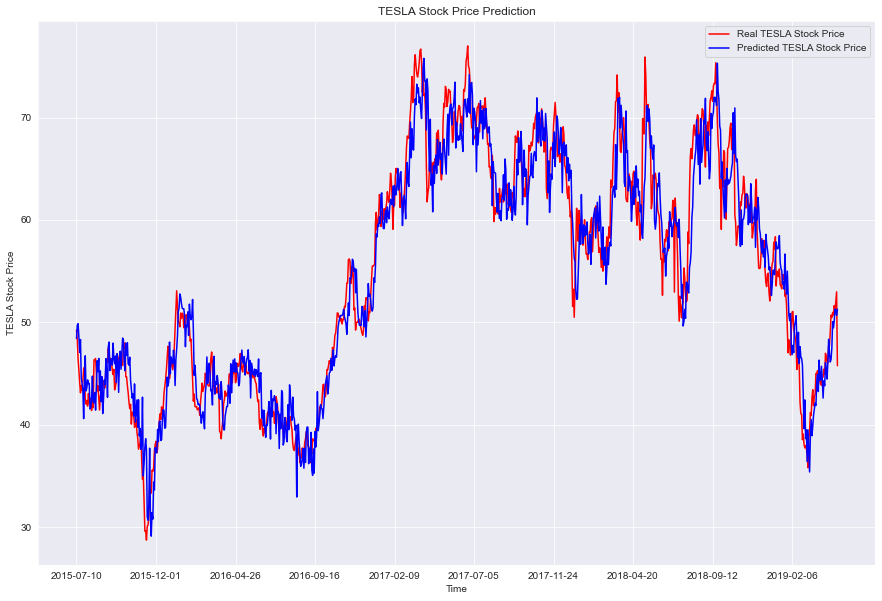

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,10))

plt.plot(df.loc[:957, 'Date'], orig[0], color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[:957, 'Date'], pred[0], color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,958,100))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Training Loss')

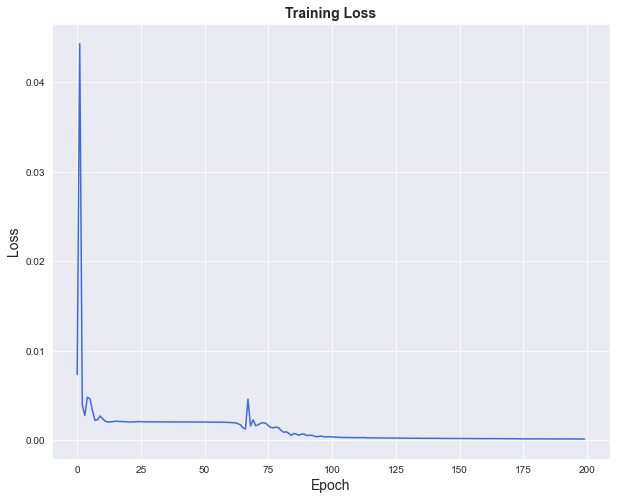

In [13]:
sns.set_style("darkgrid")
plt.figure(figsize = (10,8))
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')


In [14]:
X_test = torch.from_numpy(x_test).type(torch.Tensor)
Y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_test_pred = model(X_test)

In [15]:
pred_test = pd.DataFrame(sc.inverse_transform(y_test_pred.detach().numpy()))
orig_test = pd.DataFrame(sc.inverse_transform(Y_test.detach().numpy()))

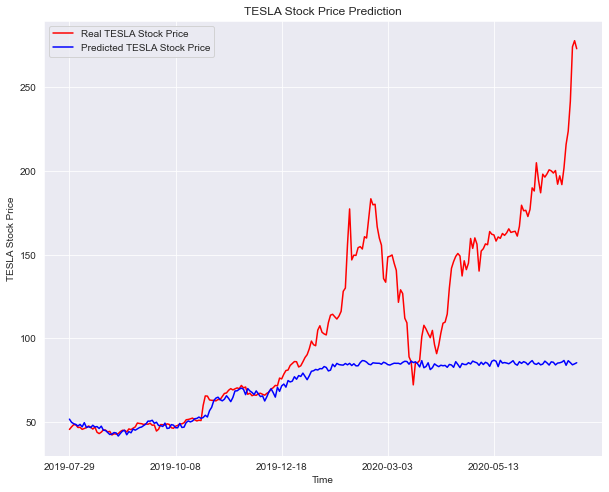

In [16]:
plt.figure(figsize = (10,8))
plt.plot(df.loc[1019:, 'Date'], orig_test[0], color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1019:, 'Date'], pred_test[0], color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,240,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

#### Model is overfitting. Test accuracy is not desirable. 

#### Time Lag = 7

In [17]:
# Time lag 7
x_train7, y_train7, x_test7, y_test7 = train_test(df1, 61, 7)

In [18]:
x_train7.shape

(958, 54, 1)

In [19]:
model2 = LSTMModel(input_dim=1, hidden_dim=50,  layer_dim=4, output_dim=1, dropout_prob=0.2)
criterion7 = torch.nn.MSELoss(reduction='mean')
optimizer7 = torch.optim.Adam(model2.parameters(), lr=0.01)

In [20]:
X_train7 = torch.from_numpy(x_train7).type(torch.Tensor)
Y_train7 = torch.from_numpy(y_train7).type(torch.Tensor)
epoch = 200
hist7 = np.zeros(epoch)
lstm7 = []
for t in range(epoch):
    y_train_pred7 = model2(X_train7)
    loss = criterion7(y_train_pred7, Y_train7)
    print("Epoch ", t, "MSE: ", loss.item())
    hist7[t] = loss.item()
    optimizer7.zero_grad()
    loss.backward()
    optimizer7.step()

Epoch  0 MSE:  0.048824697732925415
Epoch  1 MSE:  0.00213560089468956
Epoch  2 MSE:  0.07080948352813721
Epoch  3 MSE:  0.0022952454164624214
Epoch  4 MSE:  0.009697644039988518
Epoch  5 MSE:  0.012825421057641506
Epoch  6 MSE:  0.011748922988772392
Epoch  7 MSE:  0.008828281424939632
Epoch  8 MSE:  0.005437431391328573
Epoch  9 MSE:  0.00264349183999002
Epoch  10 MSE:  0.003049534512683749
Epoch  11 MSE:  0.0038267425261437893
Epoch  12 MSE:  0.002489376813173294
Epoch  13 MSE:  0.0021243924275040627
Epoch  14 MSE:  0.0021695750765502453
Epoch  15 MSE:  0.002259182510897517
Epoch  16 MSE:  0.002304059686139226
Epoch  17 MSE:  0.002218937734141946
Epoch  18 MSE:  0.0021687743719667196
Epoch  19 MSE:  0.0020892482716590166
Epoch  20 MSE:  0.0020573551300913095
Epoch  21 MSE:  0.002128686523064971
Epoch  22 MSE:  0.0021603568457067013
Epoch  23 MSE:  0.002206014469265938
Epoch  24 MSE:  0.002177765127271414
Epoch  25 MSE:  0.002110716188326478
Epoch  26 MSE:  0.00208643707446754
Epoch  

In [21]:
pred7 = pd.DataFrame(sc.inverse_transform(y_train_pred7.detach().numpy()))
orig7 = pd.DataFrame(sc.inverse_transform(Y_train7.detach().numpy()))

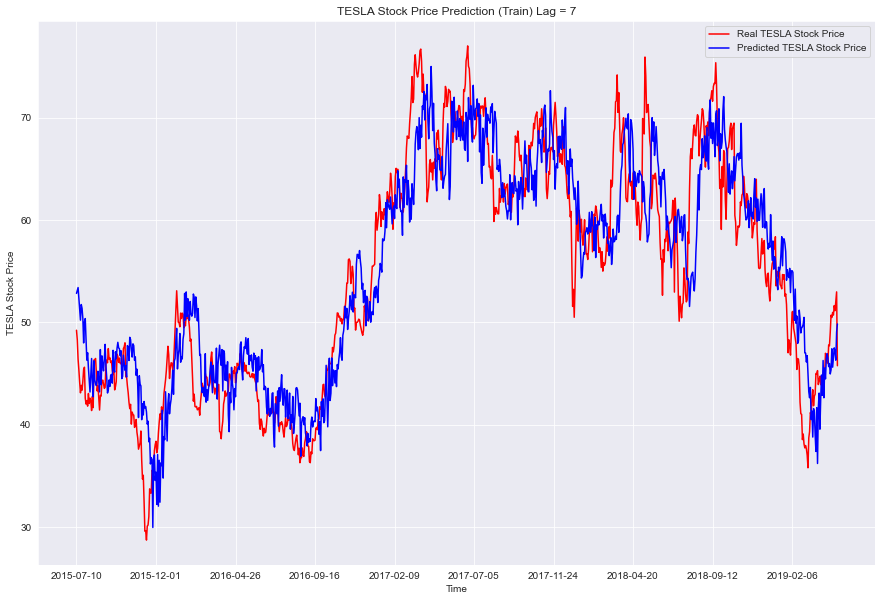

In [22]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,10))

plt.plot(df.loc[:957, 'Date'], orig7[0], color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[:957, 'Date'], pred7[0], color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,958,100))
plt.title('TESLA Stock Price Prediction (Train) Lag = 7')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Training Loss')

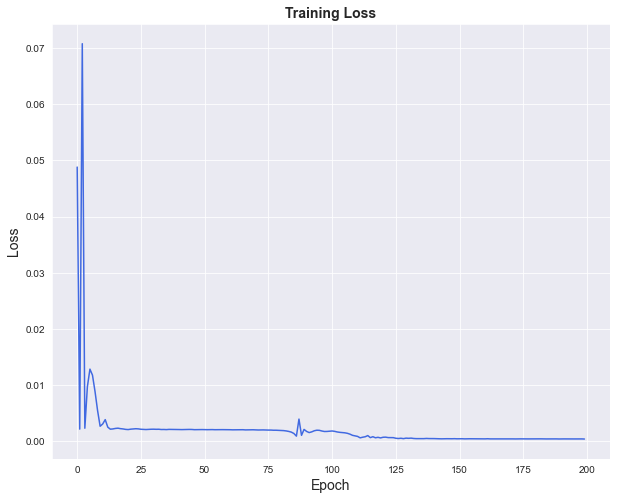

In [23]:
sns.set_style("darkgrid")
plt.figure(figsize = (10,8))
ax = sns.lineplot(data=hist7, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')

In [24]:
X_test7 = torch.from_numpy(x_test7).type(torch.Tensor)
Y_test7 = torch.from_numpy(y_test7).type(torch.Tensor)
y_test_pred7 = model(X_test7)

In [25]:
pred_test7 = pd.DataFrame(sc.inverse_transform(y_test_pred7.detach().numpy()))
orig_test7 = pd.DataFrame(sc.inverse_transform(Y_test7.detach().numpy()))

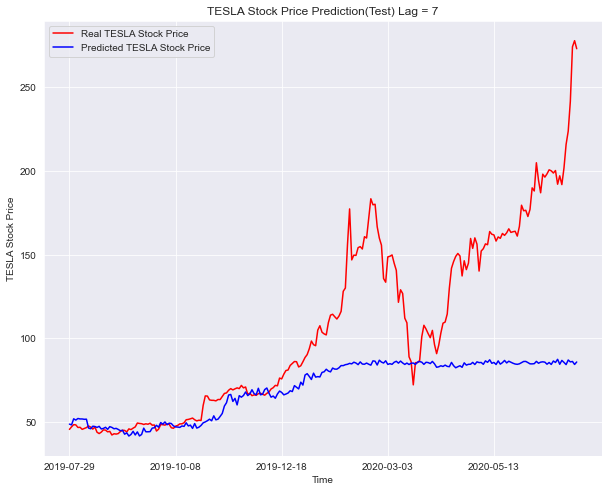

In [26]:
plt.figure(figsize = (10,8))
plt.plot(df.loc[1019:, 'Date'], orig_test7[0], color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1019:, 'Date'], pred_test7[0], color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,240,50))
plt.title('TESLA Stock Price Prediction(Test) Lag = 7')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

#### Time Lag = 14

In [27]:
# Time lag 14
x_train14, y_train14, x_test14, y_test14 = train_test(df1, 61, 14)

In [28]:
x_train14.shape

(958, 47, 1)

In [29]:
model3 = LSTMModel(input_dim=1, hidden_dim=50,  layer_dim=4, output_dim=1, dropout_prob=0.2)
criterion14 = torch.nn.MSELoss(reduction='mean')
optimizer14 = torch.optim.Adam(model3.parameters(), lr=0.01)

In [30]:
X_train14 = torch.from_numpy(x_train14).type(torch.Tensor)
Y_train14 = torch.from_numpy(y_train14).type(torch.Tensor)
epoch = 200
hist14 = np.zeros(epoch)
lstm14 = []
for t in range(epoch):
    y_train_pred14 = model3(X_train14)
    loss = criterion14(y_train_pred14, Y_train14)
    print("Epoch ", t, "MSE: ", loss.item())
    hist14[t] = loss.item()
    optimizer14.zero_grad()
    loss.backward()
    optimizer14.step()

Epoch  0 MSE:  0.054160699248313904
Epoch  1 MSE:  0.0021469807252287865
Epoch  2 MSE:  0.06138940900564194
Epoch  3 MSE:  0.0022162783425301313
Epoch  4 MSE:  0.00889033917337656
Epoch  5 MSE:  0.011409774422645569
Epoch  6 MSE:  0.009883283637464046
Epoch  7 MSE:  0.006942173466086388
Epoch  8 MSE:  0.004038088954985142
Epoch  9 MSE:  0.002223312621936202
Epoch  10 MSE:  0.002901801373809576
Epoch  11 MSE:  0.003929899074137211
Epoch  12 MSE:  0.002963142702355981
Epoch  13 MSE:  0.0022179721854627132
Epoch  14 MSE:  0.0021102686878293753
Epoch  15 MSE:  0.002267064293846488
Epoch  16 MSE:  0.002442119410261512
Epoch  17 MSE:  0.0025277493987232447
Epoch  18 MSE:  0.002421821001917124
Epoch  19 MSE:  0.002278613392263651
Epoch  20 MSE:  0.0021577472798526287
Epoch  21 MSE:  0.0020950832404196262
Epoch  22 MSE:  0.0020905386190861464
Epoch  23 MSE:  0.002159228315576911
Epoch  24 MSE:  0.002249169396236539
Epoch  25 MSE:  0.0022774781100451946
Epoch  26 MSE:  0.0022262560669332743
Epo

In [31]:
pred14 = pd.DataFrame(sc.inverse_transform(y_train_pred14.detach().numpy()))
orig14 = pd.DataFrame(sc.inverse_transform(Y_train14.detach().numpy()))

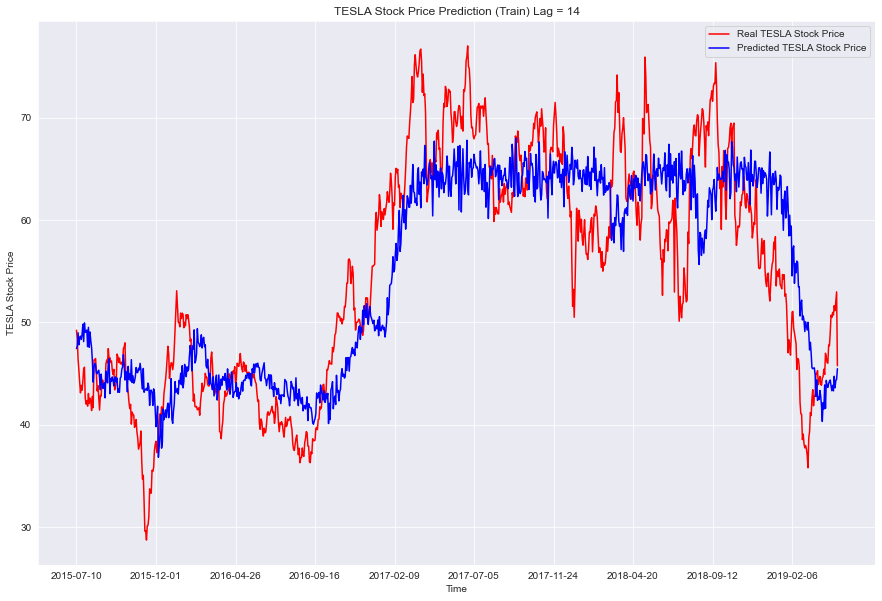

In [32]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,10))

plt.plot(df.loc[:957, 'Date'], orig14[0], color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[:957, 'Date'], pred14[0], color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,958,100))
plt.title('TESLA Stock Price Prediction (Train) Lag = 14')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Training Loss')

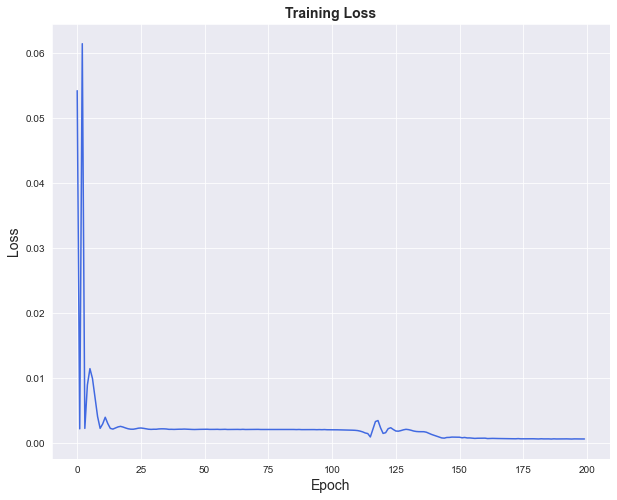

In [33]:
sns.set_style("darkgrid")
plt.figure(figsize = (10,8))
ax = sns.lineplot(data=hist14, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')

In [34]:
X_test14 = torch.from_numpy(x_test14).type(torch.Tensor)
Y_test14 = torch.from_numpy(y_test14).type(torch.Tensor)
y_test_pred14 = model(X_test14)

In [35]:
pred_test14 = pd.DataFrame(sc.inverse_transform(y_test_pred14.detach().numpy()))
orig_test14 = pd.DataFrame(sc.inverse_transform(Y_test14.detach().numpy()))

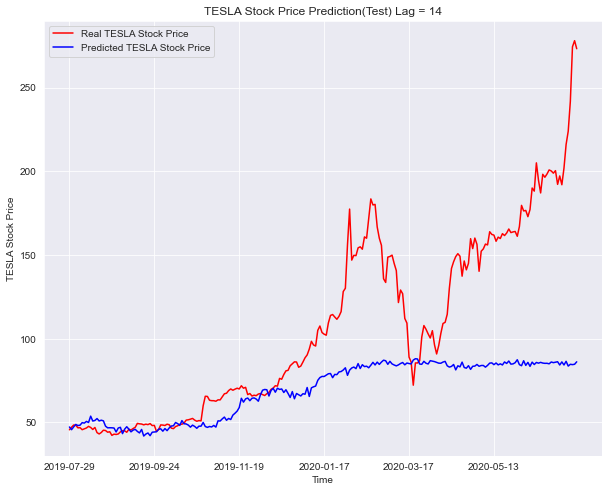

In [36]:
plt.figure(figsize = (10,8))
plt.plot(df.loc[1019:, 'Date'], orig_test14[0], color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1019:, 'Date'], pred_test14[0], color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,240,40))
plt.title('TESLA Stock Price Prediction(Test) Lag = 14')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

#### Model with 6 layers (Time Lag = 14)

In [37]:
# Time lag 14
x_train4, y_train4, x_test4, y_test4 = train_test(df1, 61, 14)

In [38]:
x_train4.shape

(958, 47, 1)

In [39]:
model4 = LSTMModel(input_dim=1, hidden_dim=50,  layer_dim=6, output_dim=1, dropout_prob=0.2)
criterion4 = torch.nn.MSELoss(reduction='mean')
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.01)

In [40]:
X_train4 = torch.from_numpy(x_train4).type(torch.Tensor)
Y_train4 = torch.from_numpy(y_train4).type(torch.Tensor)
epoch = 200
hist4 = np.zeros(epoch)
lstm4 = []
for t in range(epoch):
    y_train_pred4 = model4(X_train4)
    loss = criterion4(y_train_pred4, Y_train4)
    print("Epoch ", t, "MSE: ", loss.item())
    hist4[t] = loss.item()
    optimizer4.zero_grad()
    loss.backward()
    optimizer4.step()

Epoch  0 MSE:  0.062653087079525
Epoch  1 MSE:  0.0024858065880835056
Epoch  2 MSE:  0.005148848984390497
Epoch  3 MSE:  0.0032255109399557114
Epoch  4 MSE:  0.002110257977619767
Epoch  5 MSE:  0.0024383151903748512
Epoch  6 MSE:  0.0022365660406649113
Epoch  7 MSE:  0.0020705554634332657
Epoch  8 MSE:  0.00227719871327281
Epoch  9 MSE:  0.0022357734851539135
Epoch  10 MSE:  0.0020819210913032293
Epoch  11 MSE:  0.0021084046456962824
Epoch  12 MSE:  0.0021859228145331144
Epoch  13 MSE:  0.0021394630894064903
Epoch  14 MSE:  0.002078989055007696
Epoch  15 MSE:  0.002091294387355447
Epoch  16 MSE:  0.0021270914003252983
Epoch  17 MSE:  0.0021246711257845163
Epoch  18 MSE:  0.0020642306189984083
Epoch  19 MSE:  0.0020736660808324814
Epoch  20 MSE:  0.002109526889398694
Epoch  21 MSE:  0.0021122980397194624
Epoch  22 MSE:  0.0020852854941040277
Epoch  23 MSE:  0.002057835226878524
Epoch  24 MSE:  0.002058390062302351
Epoch  25 MSE:  0.002074688673019409
Epoch  26 MSE:  0.002090767957270145

In [41]:
pred4 = pd.DataFrame(sc.inverse_transform(y_train_pred4.detach().numpy()))
orig4 = pd.DataFrame(sc.inverse_transform(Y_train4.detach().numpy()))

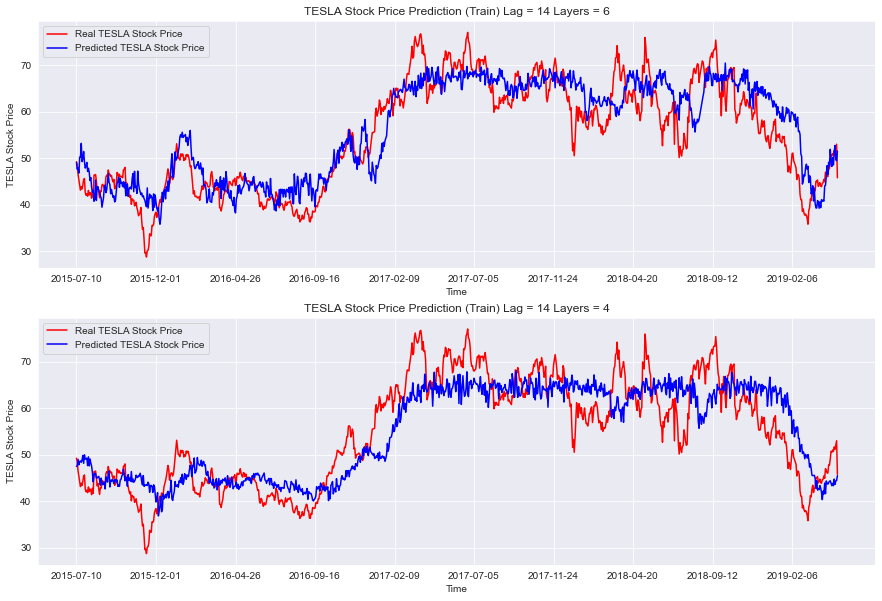

In [42]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [15,10]
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(df.loc[:957, 'Date'], orig4[0], color = 'red', label = 'Real TESLA Stock Price')
ax1.plot(df.loc[:957, 'Date'], pred4[0], color = 'blue', label = 'Predicted TESLA Stock Price')
ax1.set_xticks(np.arange(0,958,100))
ax1.set_title('TESLA Stock Price Prediction (Train) Lag = 14 Layers = 6')
ax1.set_xlabel('Time')
ax1.set_ylabel('TESLA Stock Price')
ax1.legend()
# plt.show()

ax2.plot(df.loc[:957, 'Date'], orig14[0], color = 'red', label = 'Real TESLA Stock Price')
ax2.plot(df.loc[:957, 'Date'], pred14[0], color = 'blue', label = 'Predicted TESLA Stock Price')
ax2.set_xticks(np.arange(0,958,100))
ax2.set_title('TESLA Stock Price Prediction (Train) Lag = 14 Layers = 4')
ax2.set_xlabel('Time')
ax2.set_ylabel('TESLA Stock Price')
ax2.legend()
plt.show()

Text(0.5, 1.0, 'Training Loss, Layers = 4')

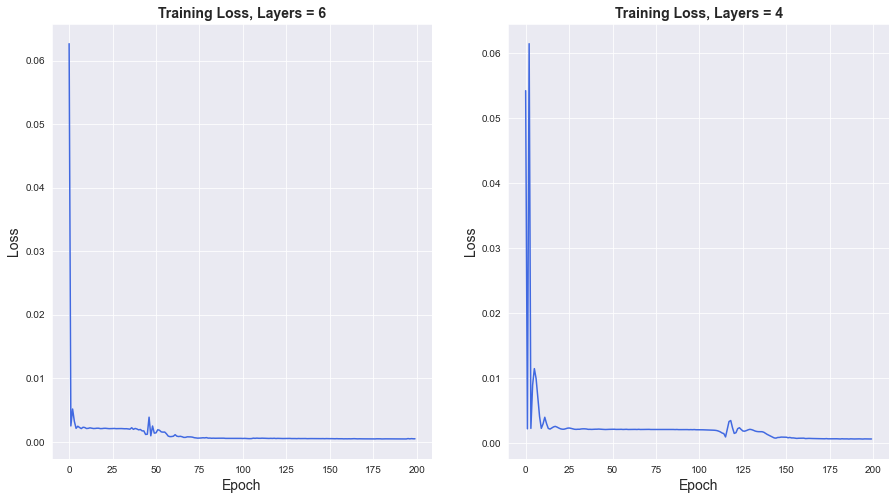

In [43]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [15,8]
fig, axs = plt.subplots(ncols=2)

ax1 = sns.lineplot(data=hist4, color='royalblue', ax = axs[0])
ax1.set_xlabel("Epoch", size = 14)
ax1.set_ylabel("Loss", size = 14)
ax1.set_title("Training Loss, Layers = 6", size = 14, fontweight='bold')

ax2 = sns.lineplot(data=hist14, color='royalblue', ax = axs[1])
ax2.set_xlabel("Epoch", size = 14)
ax2.set_ylabel("Loss", size = 14)
ax2.set_title("Training Loss, Layers = 4", size = 14, fontweight='bold')

In [44]:
X_test4 = torch.from_numpy(x_test4).type(torch.Tensor)
Y_test4 = torch.from_numpy(y_test4).type(torch.Tensor)
y_test_pred4 = model4(X_test4)

In [45]:
pred_test4 = pd.DataFrame(sc.inverse_transform(y_test_pred4.detach().numpy()))
orig_test4 = pd.DataFrame(sc.inverse_transform(Y_test4.detach().numpy()))

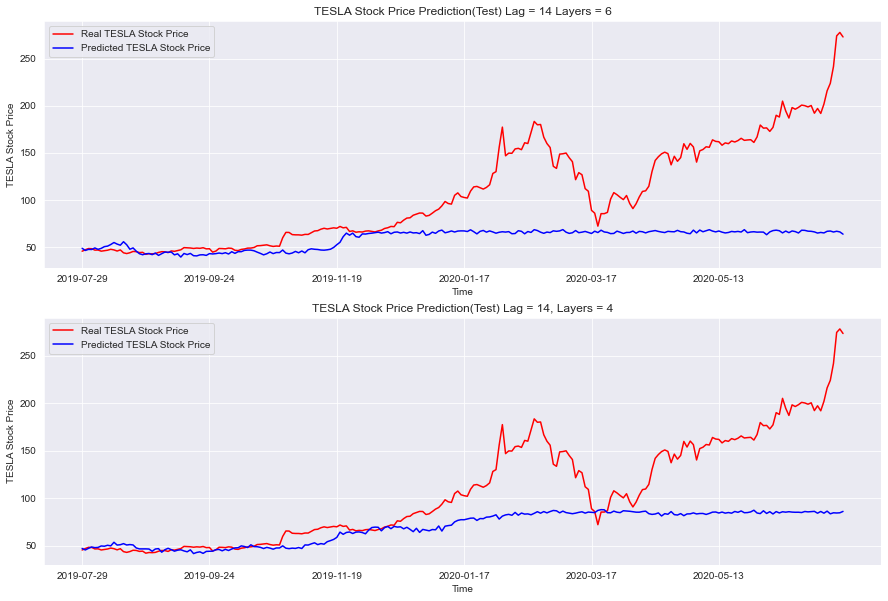

In [46]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [15,10]
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(df.loc[1019:, 'Date'], orig_test4[0], color = 'red', label = 'Real TESLA Stock Price')
ax1.plot(df.loc[1019:, 'Date'], pred_test4[0], color = 'blue', label = 'Predicted TESLA Stock Price')
ax1.set_xticks(np.arange(0,240,40))
ax1.set_title('TESLA Stock Price Prediction(Test) Lag = 14 Layers = 6')
ax1.set_xlabel('Time')
ax1.set_ylabel('TESLA Stock Price')
ax1.legend()


ax2.plot(df.loc[1019:, 'Date'], orig_test14[0], color = 'red', label = 'Real TESLA Stock Price')
ax2.plot(df.loc[1019:, 'Date'], pred_test14[0], color = 'blue', label = 'Predicted TESLA Stock Price')
ax2.set_xticks(np.arange(0,240,40))
ax2.set_title('TESLA Stock Price Prediction(Test) Lag = 14, Layers = 4')
ax2.set_xlabel('Time')
ax2.set_ylabel('TESLA Stock Price')
ax2.legend()
plt.show()

#### Dropout = 0.5,  Time Lag = 14

In [47]:
# Time lag 14
x_train5, y_train5, x_test5, y_test5 = train_test(df1, 61, 14)

In [48]:
model5 = LSTMModel(input_dim=1, hidden_dim=50,  layer_dim=4, output_dim=1, dropout_prob=0.5)
criterion5 = torch.nn.MSELoss(reduction='mean')
optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.01)

In [68]:
X_train5 = torch.from_numpy(x_train5).type(torch.Tensor)
Y_train5 = torch.from_numpy(y_train5).type(torch.Tensor)
epoch = 175
hist5 = np.zeros(epoch)
lstm5 = []
for t in range(epoch):
    y_train_pred5 = model5(X_train5)
    loss = criterion5(y_train_pred5, Y_train5)
    print("Epoch ", t, "MSE: ", loss.item())
    hist5[t] = loss.item()
    optimizer5.zero_grad()
    loss.backward()
    optimizer5.step()

Epoch  0 MSE:  0.0018416708335280418
Epoch  1 MSE:  0.0018609835533425212
Epoch  2 MSE:  0.0018914340762421489
Epoch  3 MSE:  0.0018266523256897926
Epoch  4 MSE:  0.0017330016708001494
Epoch  5 MSE:  0.0016453349962830544
Epoch  6 MSE:  0.0015562865883111954
Epoch  7 MSE:  0.0013247895985841751
Epoch  8 MSE:  0.0016429818933829665
Epoch  9 MSE:  0.002090408466756344
Epoch  10 MSE:  0.0022027858067303896
Epoch  11 MSE:  0.0014091007178649306
Epoch  12 MSE:  0.001410235883668065
Epoch  13 MSE:  0.0018774168565869331
Epoch  14 MSE:  0.0016899150796234608
Epoch  15 MSE:  0.0014415009645745158
Epoch  16 MSE:  0.001449102652259171
Epoch  17 MSE:  0.001530206180177629
Epoch  18 MSE:  0.0015877500409260392
Epoch  19 MSE:  0.0015118126757442951
Epoch  20 MSE:  0.0011846731649711728
Epoch  21 MSE:  0.0010195584036409855
Epoch  22 MSE:  0.0010674430523067713
Epoch  23 MSE:  0.0008241783361881971
Epoch  24 MSE:  0.0010207482846453786
Epoch  25 MSE:  0.0007514607859775424
Epoch  26 MSE:  0.00084481

In [69]:
pred5 = pd.DataFrame(sc.inverse_transform(y_train_pred5.detach().numpy()))
orig5 = pd.DataFrame(sc.inverse_transform(Y_train5.detach().numpy()))

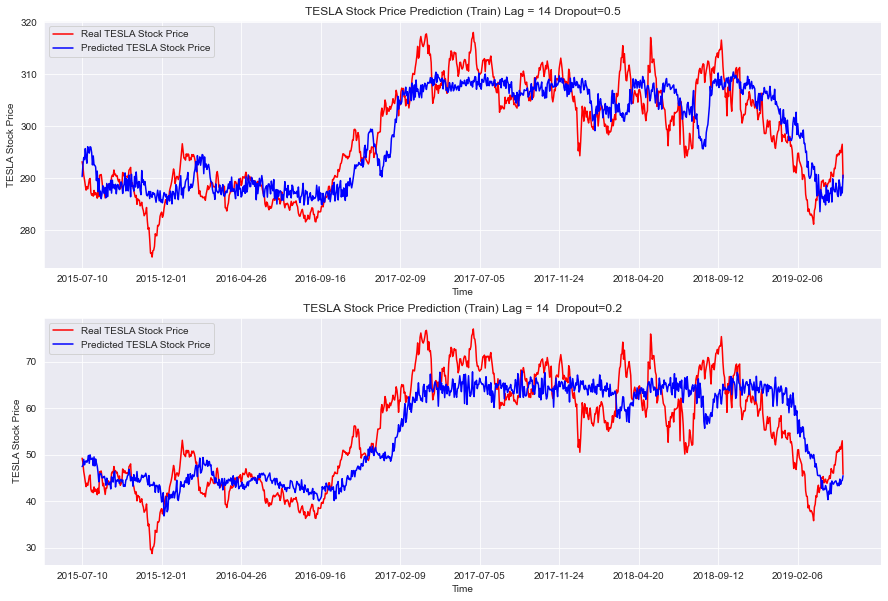

In [70]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [15,10]
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(df.loc[:957, 'Date'], orig5[0], color = 'red', label = 'Real TESLA Stock Price')
ax1.plot(df.loc[:957, 'Date'], pred5[0], color = 'blue', label = 'Predicted TESLA Stock Price')
ax1.set_xticks(np.arange(0,958,100))
ax1.set_title('TESLA Stock Price Prediction (Train) Lag = 14 Dropout=0.5')
ax1.set_xlabel('Time')
ax1.set_ylabel('TESLA Stock Price')
ax1.legend()
# plt.show()

ax2.plot(df.loc[:957, 'Date'], orig14[0], color = 'red', label = 'Real TESLA Stock Price')
ax2.plot(df.loc[:957, 'Date'], pred14[0], color = 'blue', label = 'Predicted TESLA Stock Price')
ax2.set_xticks(np.arange(0,958,100))
ax2.set_title('TESLA Stock Price Prediction (Train) Lag = 14  Dropout=0.2')
ax2.set_xlabel('Time')
ax2.set_ylabel('TESLA Stock Price')
ax2.legend()
plt.show()

Text(0.5, 1.0, 'Training Loss, Dropout = 0.2')

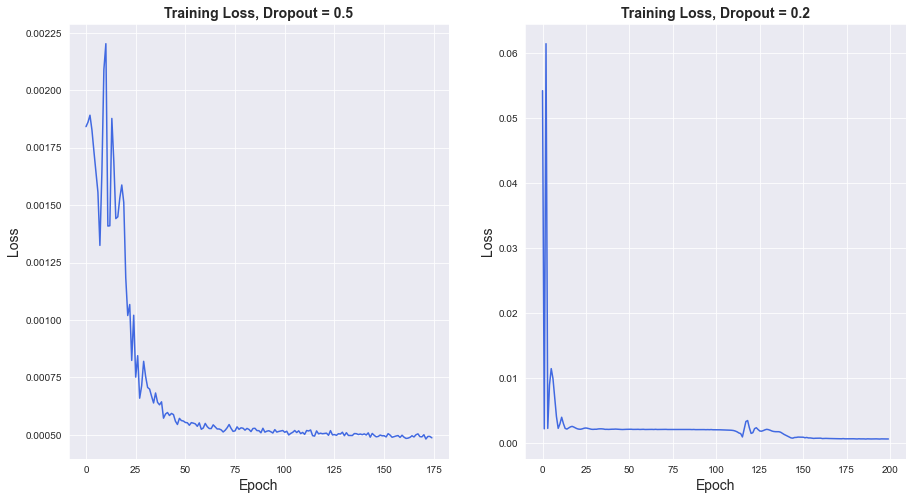

In [71]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [15,8]
fig, axs = plt.subplots(ncols=2)

ax1 = sns.lineplot(data=hist5, color='royalblue', ax = axs[0])
ax1.set_xlabel("Epoch", size = 14)
ax1.set_ylabel("Loss", size = 14)
ax1.set_title("Training Loss, Dropout = 0.5", size = 14, fontweight='bold')

ax2 = sns.lineplot(data=hist14, color='royalblue', ax = axs[1])
ax2.set_xlabel("Epoch", size = 14)
ax2.set_ylabel("Loss", size = 14)
ax2.set_title("Training Loss, Dropout = 0.2", size = 14, fontweight='bold')

In [72]:
X_test5 = torch.from_numpy(x_test5).type(torch.Tensor)
Y_test5 = torch.from_numpy(y_test5).type(torch.Tensor)
y_test_pred5 = model5(X_test5)

In [73]:
pred_test5 = pd.DataFrame(sc.inverse_transform(y_test_pred5.detach().numpy()))
orig_test5 = pd.DataFrame(sc.inverse_transform(Y_test5.detach().numpy()))

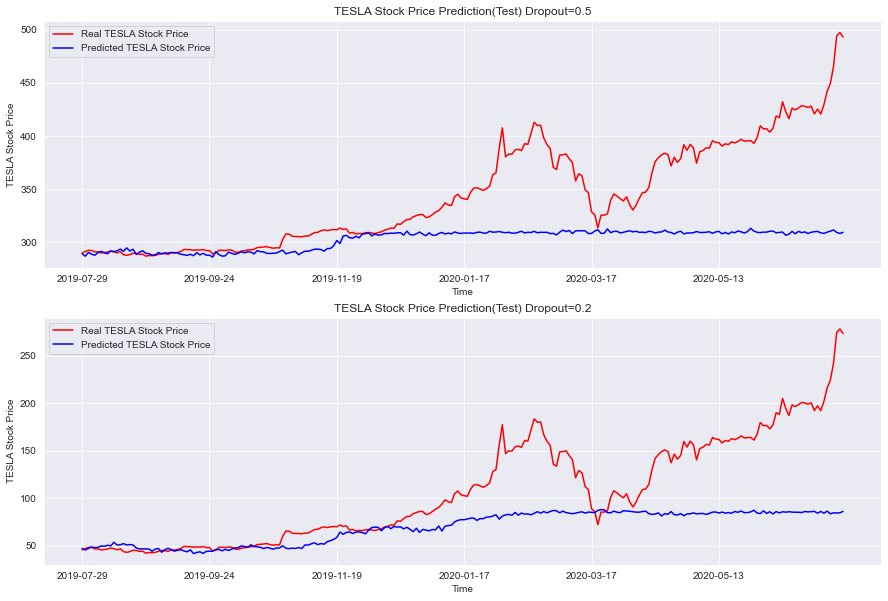

In [74]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [15,10]
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(df.loc[1019:, 'Date'], orig_test5[0], color = 'red', label = 'Real TESLA Stock Price')
ax1.plot(df.loc[1019:, 'Date'], pred_test5[0], color = 'blue', label = 'Predicted TESLA Stock Price')
ax1.set_xticks(np.arange(0,240,40))
ax1.set_title('TESLA Stock Price Prediction(Test) Dropout=0.5')
ax1.set_xlabel('Time')
ax1.set_ylabel('TESLA Stock Price')
ax1.legend()


ax2.plot(df.loc[1019:, 'Date'], orig_test14[0], color = 'red', label = 'Real TESLA Stock Price')
ax2.plot(df.loc[1019:, 'Date'], pred_test14[0], color = 'blue', label = 'Predicted TESLA Stock Price')
ax2.set_xticks(np.arange(0,240,40))
ax2.set_title('TESLA Stock Price Prediction(Test) Dropout=0.2')
ax2.set_xlabel('Time')
ax2.set_ylabel('TESLA Stock Price')
ax2.legend()
plt.show()

### Forecast

#### Applying the first Model. Time lag = 1, Layers = 4, Dropout = 0.4

In [56]:
df_new = pd.read_csv(os.path.join(filepath, 'TSLA2.csv'))
df_new.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-09,279.398010,281.712006,270.256012,278.855988,278.855988,58588000
1,2020-07-10,279.200012,309.783997,275.201996,308.929993,308.929993,116688000
2,2020-07-13,331.799988,358.997986,294.221985,299.411987,299.411987,194927000


In [57]:
df_new.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
78,2020-10-28,416.480011,418.600006,406.000000,406.019989,406.019989,25451400
79,2020-10-29,409.959991,418.059998,406.459991,410.829987,410.829987,22655300
80,2020-10-30,406.899994,407.589996,379.109985,388.040009,388.040009,42511300


In [58]:
df_new[['Close']]

,Close
0,278.855988
1,308.929993
2,299.411987
3,303.359985
4,309.201996
...,...
76,420.279999
77,424.679993
78,406.019989
79,410.829987


In [59]:
df2 = df_new[['Close']]
sc = MinMaxScaler(feature_range=(0, 1))
df2['Close'] = sc.fit_transform(df2['Close'].values.reshape(-1,1))

<ipython-input-59-b7440f2c596e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Close'] = sc.fit_transform(df2['Close'].values.reshape(-1,1))


In [84]:
# Train-Test Split
def train_test2(stock, step, n):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw)-step): 
        data.append(data_raw[index: index + step])
    
    data = np.array(data)
    data_size = data.shape[0]
    
    x = data[:data_size,:-n]
    y = data[:data_size,-1,:]
    
    return [x, y]

In [87]:
x, y = train_test2(df2, 20, 14)

In [88]:
y.shape

(61, 1)

In [89]:
x.shape

(61, 6, 1)

In [93]:
model6 = LSTMModel(input_dim=1, hidden_dim=50,  layer_dim=4, output_dim=1, dropout_prob=0.2)
criterion6 = torch.nn.MSELoss(reduction='mean')
optimizer6 = torch.optim.Adam(model6.parameters(), lr=0.01)

In [94]:
X1 = torch.from_numpy(x).type(torch.Tensor)
Y1 = torch.from_numpy(y).type(torch.Tensor)
epoch = 200
hist6 = np.zeros(epoch)
lstm6 = []
for t in range(epoch):
    y_train_pred6 = model6(X1)
    loss = criterion6(y_train_pred6, Y1)
    print("Epoch ", t, "MSE: ", loss.item())
    hist6[t] = loss.item()
    optimizer6.zero_grad()
    loss.backward()
    optimizer6.step()

Epoch  0 MSE:  0.3447767496109009
Epoch  1 MSE:  0.15123067796230316
Epoch  2 MSE:  0.08191626518964767
Epoch  3 MSE:  0.04877982661128044
Epoch  4 MSE:  0.05556954815983772
Epoch  5 MSE:  0.05752618983387947
Epoch  6 MSE:  0.051929179579019547
Epoch  7 MSE:  0.04881223663687706
Epoch  8 MSE:  0.05324668064713478
Epoch  9 MSE:  0.052223339676856995
Epoch  10 MSE:  0.04856541007757187
Epoch  11 MSE:  0.04786798357963562
Epoch  12 MSE:  0.04958602786064148
Epoch  13 MSE:  0.050775669515132904
Epoch  14 MSE:  0.05018753558397293
Epoch  15 MSE:  0.048421718180179596
Epoch  16 MSE:  0.04722173139452934
Epoch  17 MSE:  0.04870154708623886
Epoch  18 MSE:  0.049324654042720795
Epoch  19 MSE:  0.04850113019347191
Epoch  20 MSE:  0.046330682933330536
Epoch  21 MSE:  0.045969460159540176
Epoch  22 MSE:  0.04567348584532738
Epoch  23 MSE:  0.04385434091091156
Epoch  24 MSE:  0.04217616096138954
Epoch  25 MSE:  0.040352486073970795
Epoch  26 MSE:  0.04005570709705353
Epoch  27 MSE:  0.0398575253784

In [95]:
X = torch.from_numpy(x).type(torch.Tensor)
Y = torch.from_numpy(y).type(torch.Tensor)
y_pred = model6(X)

In [96]:
pred_y = pd.DataFrame(sc.inverse_transform(y_pred.detach().numpy()))
orig_y = pd.DataFrame(sc.inverse_transform(Y.detach().numpy().reshape(-1, 1)))

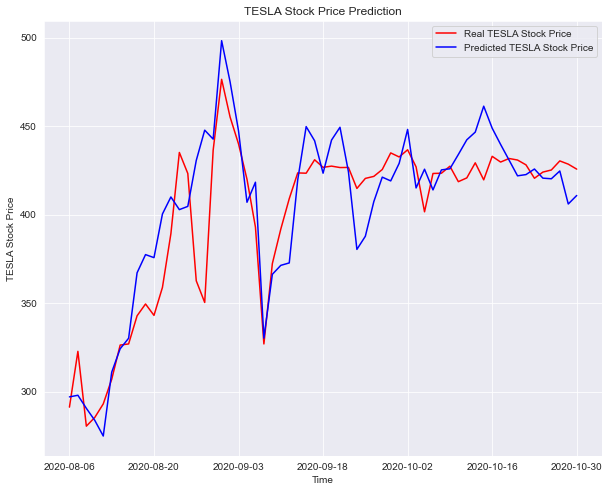

In [97]:
plt.figure(figsize = (10,8))
plt.plot(df_new.loc[20:, 'Date'], pred_y[0], color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df_new.loc[20:, 'Date'], orig_y[0], color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,61,10))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [ ]:
#